## Project Objectives



#### 1. Predicting Delivery Time


## Attributes in Dataset

## Importing Required libraries

In [1]:
pip install geopy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [4]:
import pandas as pd


file_path = '/Users/rammanyala/Downloads/FOOD DELIVERY/train.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Displaying the first few rows of the DataFrame to ensure the data is loaded correctly
display(df.head(8))




,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
5,0x9bb4,HYDRES09DEL03,22,4.8,17.431668,78.408321,17.461668,78.438321,11-03-2022,21:20:00,21:30:00,conditions Cloudy,Jam,0,Buffet,motorcycle,1,No,Urban,(min) 26
6,0x95b4,RANCHIRES15DEL01,33,4.7,23.369746,85.339820,23.479746,85.449820,04-03-2022,19:15:00,19:30:00,conditions Fog,Jam,1,Meal,scooter,1,No,Metropolitian,(min) 40
7,0x9eb2,MYSRES15DEL02,35,4.6,12.352058,76.606650,12.482058,76.736650,14-03-2022,17:25:00,17:30:00,conditions Cloudy,Medium,2,Meal,motorcycle,1,No,Metropolitian,(min) 32


In [5]:
df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [6]:
# Displaying the shape of the DataFrame
print("Shape of the dataset:", df.shape)


Shape of the dataset: (45593, 20)


## Data cleaning and Data Transformation

In [7]:
#Data Extraction
def extract_data(data):
    if "Time_taken(min)" in data.columns:
        data["Time_taken(min)"]=data["Time_taken(min)"].apply(lambda x: int(x.split(" ")[1].strip()))
        data["Weatherconditions"]=data["Weatherconditions"].apply(lambda x: x.split(" ")[1].strip())
        data["Code"]=data["Delivery_person_ID"].str.split("RES", expand=True)[0]
        data.replace("NaN", float(np.nan), regex=True, inplace=True)
    else:
        data["Weatherconditions"]=data["Weatherconditions"].apply(lambda x: x.split(" ")[1].strip())
        data["Code"]=data["Delivery_person_ID"].str.split("RES", expand=True)[0]
        data.replace("NaN", float(np.nan), regex=True, inplace=True)
    return data


df=extract_data(df)
df[["Time_taken(min)","Weatherconditions","Code"]].head()



,Time_taken(min),Weatherconditions,Code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


In [8]:
#Dropping  columns which are not needed
df.drop(["ID","Delivery_person_ID"],axis=1,inplace=True)
df.shape


(45593, 19)

In [9]:

df['Time_Orderd'] = df['Order_Date'] + ' ' + df['Time_Orderd']
df['Time_Order_picked'] = df['Order_Date'] + ' ' + df['Time_Order_picked']

df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], format='%d-%m-%Y %H:%M:%S')
df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'], format='%d-%m-%Y %H:%M:%S')

In [10]:
#Check for Duplicate Values
if (len(df[df.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [11]:
#Update datatypes
def update_datatype(df):
    #Update datatype from object to float
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    #Update datatype from object to datetime
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
    
update_datatype(df)


In [12]:
#Removing extra spaces
for feature in df.select_dtypes(include = 'O').columns:
    df[feature] = df[feature].apply(lambda value: np.nan if pd.isnull(value) else value.replace(' ', ''))

In [13]:
df.isnull().sum()

Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
Code                              0
dtype: int64

In [14]:
#Handle Missing Values
df.isnull().sum()[df.isnull().sum()>0]

#Order_day and Time_Orderd had 1731 missing values and 
#due to that the  time engineered features (Order Ready Time, Order_Year , Order_Month ,Order_Day) also have the same amount of missing values. 

Delivery_person_Age        1854
Delivery_person_Ratings    1908
Time_Orderd                1731
Weatherconditions           616
Road_traffic_density        601
multiple_deliveries         993
Festival                    228
City                       1200
dtype: int64

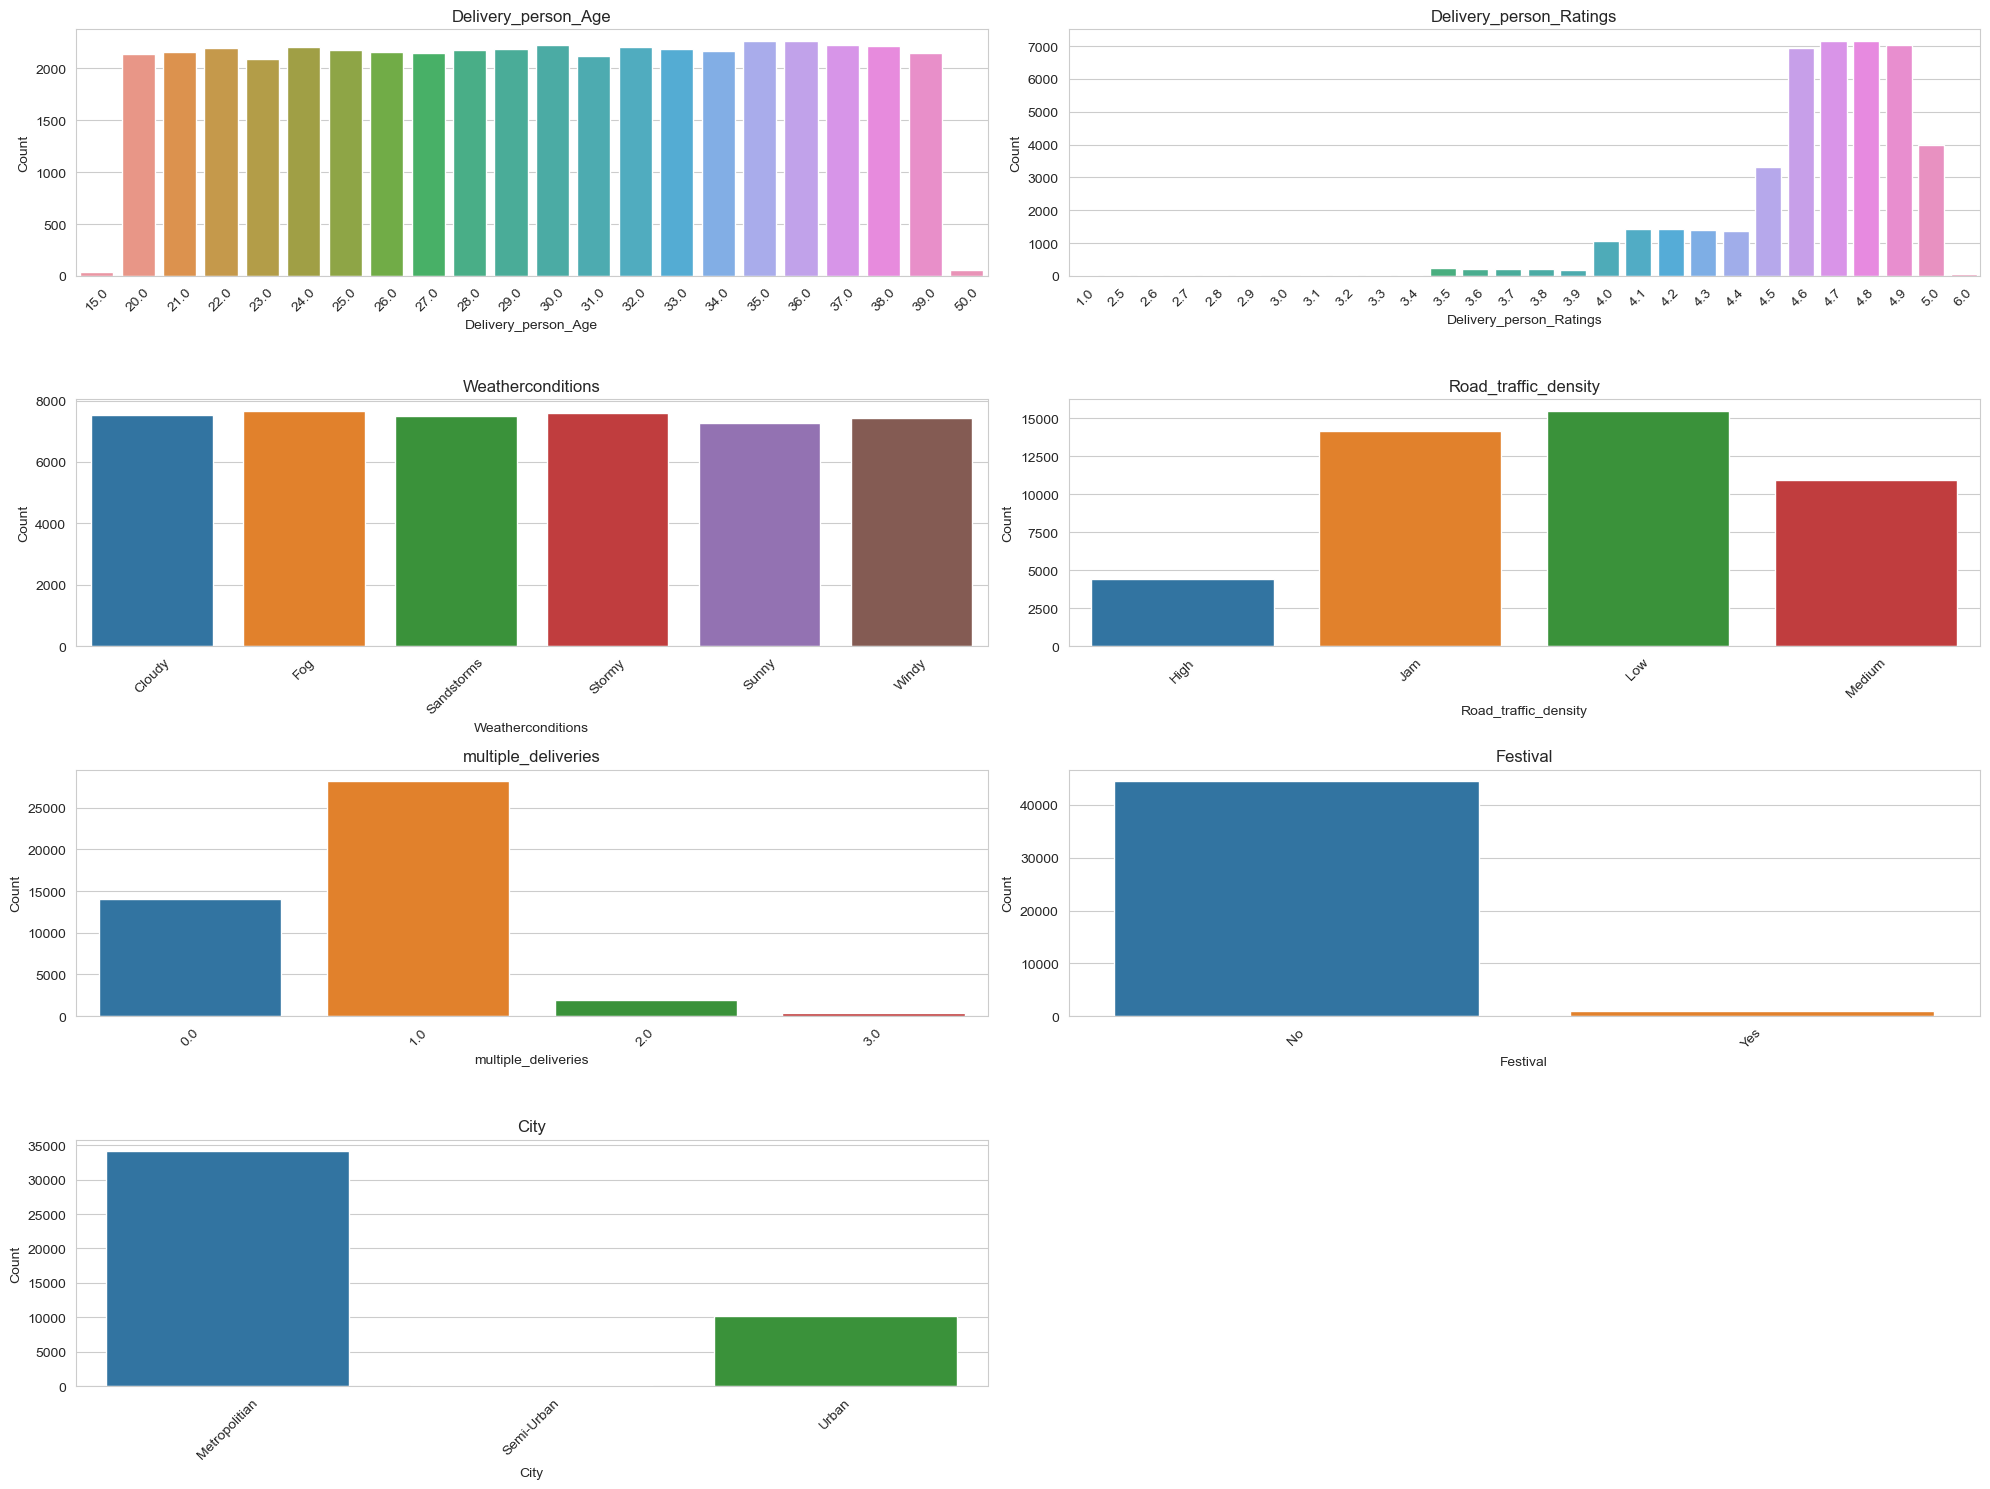

In [15]:
#Data Visualisation
#plotting the count of occurrences of each value in the feature,can simply label the y-axis as "Frequency" or "Count".
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weatherconditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('Count')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)
    
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [16]:
#Handle null values
def handle_null_values(df):
    df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df['Weatherconditions'].fillna(np.random.choice(df['Weatherconditions']), inplace=True)
    df['City'].fillna(df['City'].mode()[0], inplace=True)
    df['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)
    
handle_null_values(df)


In [17]:
df.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
Code                              0
dtype: int64

## Feature Engineering

In [18]:
def extract_date_features(data):
    data["day"]=data["Order_Date"].dt.day
    data["month"]=data["Order_Date"].dt.month
    data["year"]=data["Order_Date"].dt.year
    data["day_of_week"]=data["Order_Date"].dt.day_of_week.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)
    return data

df=extract_date_features(df)
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Code,day,month,year,day_of_week,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,2022-03-19 11:30:00,2022-03-19 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,2022,5,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,2022-03-25 19:45:00,2022-03-25 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,2022,4,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,2022-03-19 08:30:00,2022-03-19 08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,2022,5,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,2022-04-05 18:00:00,2022-04-05 18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2022,1,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,2022-03-26 13:30:00,2022-03-26 13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,2022,5,1


In [19]:
import numpy as np
import pandas as pd

def calculate_prepare_time_and_extract(data):
    # Initialize a new column for the adjusted picked time
    data["Time_order_picked2"] = np.nan
    
    # Iterate over each row in the DataFrame
    for i in range(len(data)):
        # Check if the picked time is less than the ordered time
        if (data.loc[i, "Time_Order_picked"] < data.loc[i, "Time_Orderd"] and pd.notna(data.loc[i, "Time_Orderd"])): 
            # If so, add one day to the picked time
            data.loc[i, "Time_order_picked2"] = data.loc[i, "Time_Order_picked"] + pd.DateOffset(days=1)
        # Check if the picked time is greater than the ordered time
        elif (data.loc[i, "Time_Order_picked"] > data.loc[i, "Time_Orderd"] and pd.notna(data.loc[i, "Time_Orderd"])): 
            # If so, keep the picked time unchanged
            data.loc[i, "Time_order_picked2"] = data.loc[i, "Time_Order_picked"]
        else:
            # If the conditions are not met, continue to the next iteration
            continue
                
    # Convert the adjusted picked time to datetime format
    data["Time_order_picked2"] = pd.to_datetime(data["Time_order_picked2"], format="%Y-%m-%d %H:%M:%S")   
    
    # Copy the ordered time for further processing
    data["Time_orderd2"] = data["Time_Orderd"]
    
    # Calculate the order prepare time in minutes
    data["order_prepare_time"] = (data["Time_order_picked2"] - data["Time_orderd2"]).dt.total_seconds() / 60
    
    # Create a new column for the hour of the order
    data["Order_hour"] = data["Time_orderd2"].dt.hour
    
    # Assign time periods based on the order hour
    data["order_time_period"] = np.where(data["Order_hour"].isin([0,1,2,3,4,5]), "night",
                                          np.where(data["Order_hour"].isin([6,7,8,9,10,11]), "morning",
                                                  np.where(data["Order_hour"].isin([12,13,14]), "noon",
                                                          np.where(data["Order_hour"].isin([15,16,17,18,19]), "afternoon", "evening"))))
    
    # Handle null values in the order prepare time by filling with the median
    data["order_prepare_time"].fillna(data["order_prepare_time"].median(), inplace=True)
    
    # Remove the intermediate columns and unused columns from the dataset
    data.drop(["Time_Orderd", "Time_Order_picked", "Time_orderd2", "Time_order_picked2", "Order_hour", "Order_Date"], axis=1, inplace=True)
    
    return data

# Apply the function to the DataFrame
df = calculate_prepare_time_and_extract(df)
df.head()


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Code,day,month,year,day_of_week,is_weekend,order_prepare_time,order_time_period
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,2022,5,1,15.0,morning
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,2022,4,0,5.0,afternoon
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,2022,5,1,15.0,morning
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2022,1,0,10.0,afternoon
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,2022,5,1,15.0,noon


In [20]:
# radian to degree
def rad2deg(radians):
    degrees=  radians * 180 / np.pi
    return degrees

# degree to radian
def deg2rad(degrees):
    radians = degrees * np.pi / 180
    return radians

def calculate_distance(lat1,long1,lat2,long2,unit = "miles"):
    
    theta=long1-long2
    
    distance=60 * 1.1515 * rad2deg(
    np.arccos(
        (np.sin(deg2rad(lat1)) * np.sin(deg2rad(lat2))) + 
        (np.cos(deg2rad(lat1))* np.cos(deg2rad(lat2)) * np.cos(deg2rad(theta))))
    )
    
    if unit == "miles":
        return round(distance,2)
    if unit == "kilometers":
        return round(distance * 1.609344, 2)

In [21]:
def distance(data):
    data['distance'] = np.nan

    for i in range(len(data)):
        data.loc[i, 'distance'] = calculate_distance(data.loc[i, 'Restaurant_latitude'], 
                                                     data.loc[i, 'Restaurant_longitude'], 
                                                     data.loc[i, 'Delivery_location_latitude'], 
                                                     data.loc[i, 'Delivery_location_longitude'],
                                                    unit="kilometers")
    data.drop(["Restaurant_latitude","Restaurant_longitude","Delivery_location_latitude","Delivery_location_longitude"],axis=1,inplace=True)
    return data

df=distance(df)
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Code,day,month,year,day_of_week,is_weekend,order_prepare_time,order_time_period,distance
0,37.0,4.9,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,2022,5,1,15.0,morning,3.03
1,34.0,4.5,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,2022,4,0,5.0,afternoon,20.18
2,23.0,4.4,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,2022,5,1,15.0,morning,1.55
3,38.0,4.7,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2022,1,0,10.0,afternoon,7.79
4,32.0,4.6,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,2022,5,1,15.0,noon,6.21


In [22]:
df.isnull().sum()

Delivery_person_Age        0
Delivery_person_Ratings    0
Weatherconditions          0
Road_traffic_density       0
Vehicle_condition          0
Type_of_order              0
Type_of_vehicle            0
multiple_deliveries        0
Festival                   0
City                       0
Time_taken(min)            0
Code                       0
day                        0
month                      0
year                       0
day_of_week                0
is_weekend                 0
order_prepare_time         0
order_time_period          0
distance                   0
dtype: int64

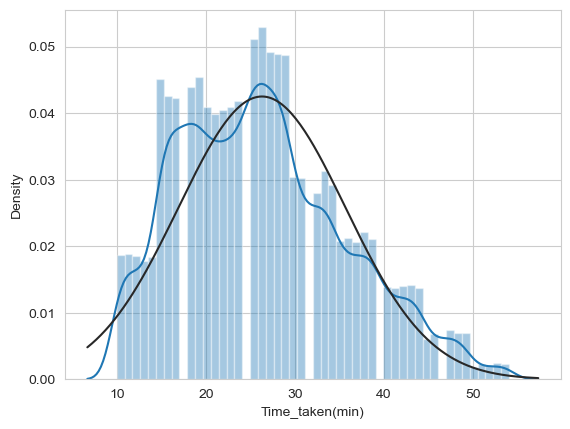

In [23]:
# Import necessary libraries
from scipy.stats import norm, skew
import seaborn as sns

# Extract the 'Time_taken(min)' data from the DataFrame
delivery_time = df["Time_taken(min)"]

# Plot the distribution of delivery times along with a fitted normal distribution curve
sns.distplot(delivery_time, fit=norm);


In [24]:
# Fit a normal distribution to the delivery time data and extract the mean (mu) and standard deviation (sigma)
(mu, sigma) = norm.fit(delivery_time)

# Print the mean (mu) and standard deviation (sigma)
print("mu: {}, sigma: {}".format(mu, sigma))


mu: 26.29460662821047, sigma: 9.383703236190236


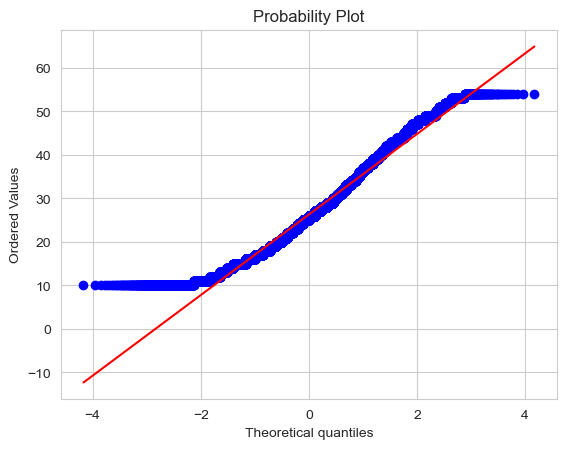

In [25]:
# Import necessary libraries

import scipy.stats as stats

# Create a new figure for the Q-Q plot
plt.figure()

# Generate a Q-Q plot using the delivery time data
stats.probplot(delivery_time, plot=plt)

# Display the Q-Q plot
plt.show()

#A Q-Q plot is used to visually assess whether a dataset follows a particular theoretical distribution (in this case, a normal distribution). 
#The probplot function calculates the quantiles of the delivery time data and compares them to the quantiles of a theoretical normal distribution.

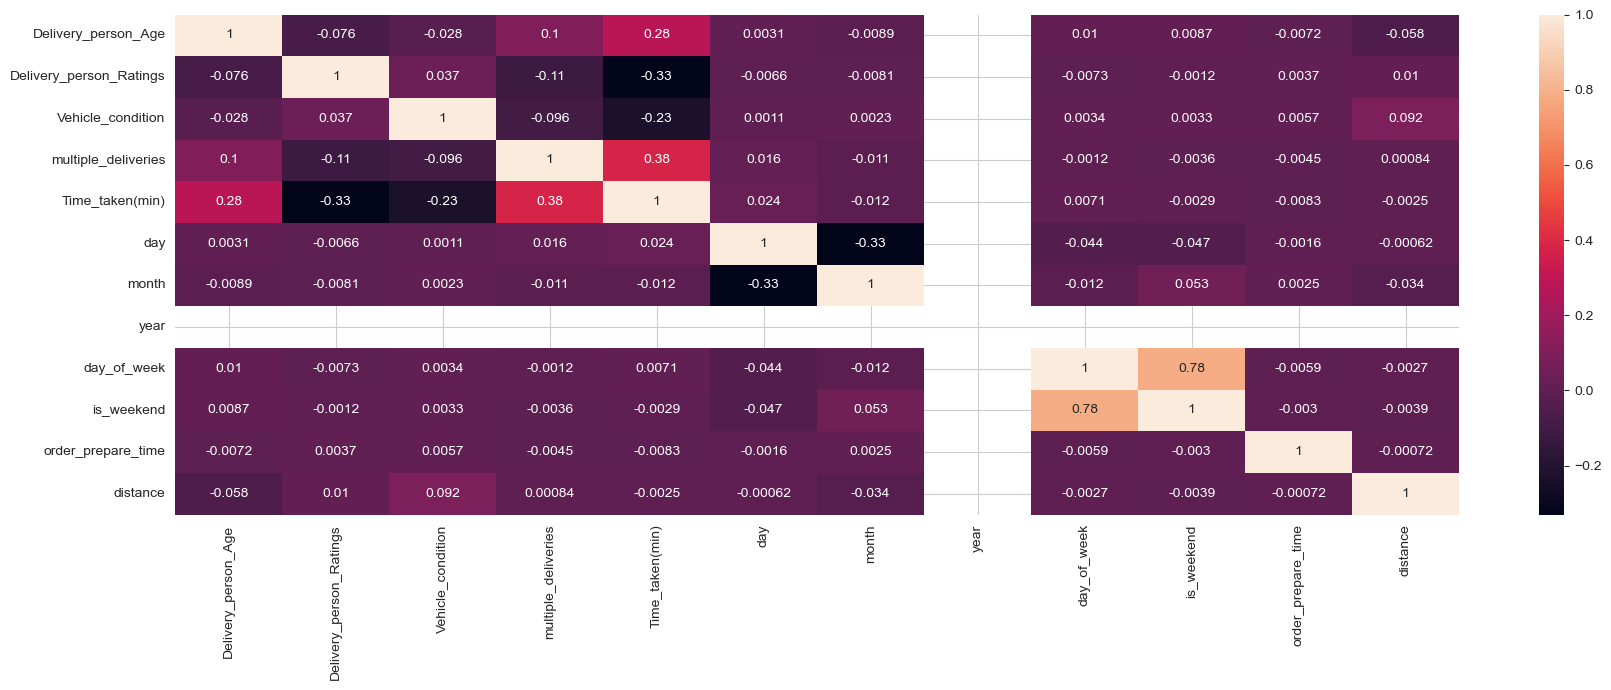

In [26]:
plt.figure(figsize=(18,7))
sns.heatmap(df.corr(),annot=True)
plt.tight_layout()

## Data Transformation

In [27]:
def label_encoding(df):
    # Selecting only the categorical columns in the DataFrame
    categorical_columns = df.select_dtypes(include='object').columns
    
    # Initializing a LabelEncoder object to encode categorical variables
    label_encoder = LabelEncoder()
    
    # Applying label encoding to each categorical column individually
    # Using lambda function to apply fit_transform to each column
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

# Applying label encoding to the DataFrame
label_encoding(df)

print(df.dtypes)


#If the categorical columns have been successfully label encoded, their data type should change from 'object' to 'int64' or 'int32',
#depending on the size of the dataset. 

Delivery_person_Age        float64
Delivery_person_Ratings    float64
Weatherconditions            int64
Road_traffic_density         int64
Vehicle_condition            int64
Type_of_order                int64
Type_of_vehicle              int64
multiple_deliveries        float64
Festival                     int64
City                         int64
Time_taken(min)              int64
Code                         int64
day                          int64
month                        int64
year                         int64
day_of_week                  int64
is_weekend                   int64
order_prepare_time         float64
order_time_period            int64
distance                   float64
dtype: object


## EDA

In [28]:
df.describe().T.head()

#Mean: The average value of the data points. It is calculated by summing all the values and dividing by the total number of values.
#Minimum: The smallest value in the dataset.
#25th Percentile (Q1): Also known as the first quartile, it is the value below which 25% of the data falls. It represents the lower end of the middle 50% of the data.
#Median (50th Percentile): The middle value of the dataset when it is ordered from least to greatest. It separates the higher half from the lower half of the data.
#75th Percentile (Q3): Also known as the third quartile, it is the value below which 75% of the data falls. It represents the upper end of the middle 50% of the data.
#Maximum: The largest value in the dataset.
#Standard Deviation: A measure of the amount of variation or dispersion in a set of values.
#It quantifies the amount of variation or dispersion from the mean value. 
#A low standard deviation indicates that the data points tend to be close to the mean, 
#while a high standard deviation indicates that the data points are spread out over a wider range of values.

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,45593.0,29.218762,5.941732,15.0,24.0,29.0,34.0,50.0
Delivery_person_Ratings,45593.0,4.636552,0.327906,1.0,4.6,4.7,4.8,6.0
Weatherconditions,45593.0,2.489330,1.695195,0.0,1.0,3.0,4.0,5.0
Road_traffic_density,45593.0,1.735793,0.932059,0.0,1.0,2.0,2.0,3.0
Vehicle_condition,45593.0,1.023359,0.839065,0.0,0.0,1.0,2.0,3.0


In [29]:
len(df["Delivery_person_Ratings"].unique()) # We will take it as a continuous variable
# Counting the number of unique delivery person ratings to assess data variability and quality



28

In [30]:
# Storing the names of categorical variables with a maximum value less than 7
# Excluding "Delivery_person_Ratings" since it's treated as a continuous variable
# Adding "day" to the list as it represents a categorical variable indicating the day of the week
cat_cols = df.describe().T[df.describe().T["max"] < 7].index.to_list()
cat_cols.remove("Delivery_person_Ratings")  # Remove delivery person ratings from the list
cat_cols.append("day")  # Add "day" to the list as it represents a categorical variable
cat_cols

['Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'Type_of_order',
 'Type_of_vehicle',
 'multiple_deliveries',
 'Festival',
 'City',
 'month',
 'day_of_week',
 'is_weekend',
 'order_time_period',
 'day']

In [31]:
df["year"].value_counts() # The year variable consists of a single value. So we will remove it from the data set.

2022    45593
Name: year, dtype: int64

In [32]:
# Storing the names of numeric variables with a maximum value greater than 7
# Excluding "day" and "year" since they are not considered continuous numeric variables
num_cols = df.describe().T[df.describe().T["max"] > 7].index.to_list()
num_cols.remove("day")  # Remove "day" from the list as it's not a continuous numeric variable
num_cols.remove("year")  # Remove "year" from the list as it's not a continuous numeric variable
num_cols

['Delivery_person_Age',
 'Time_taken(min)',
 'Code',
 'order_prepare_time',
 'distance']

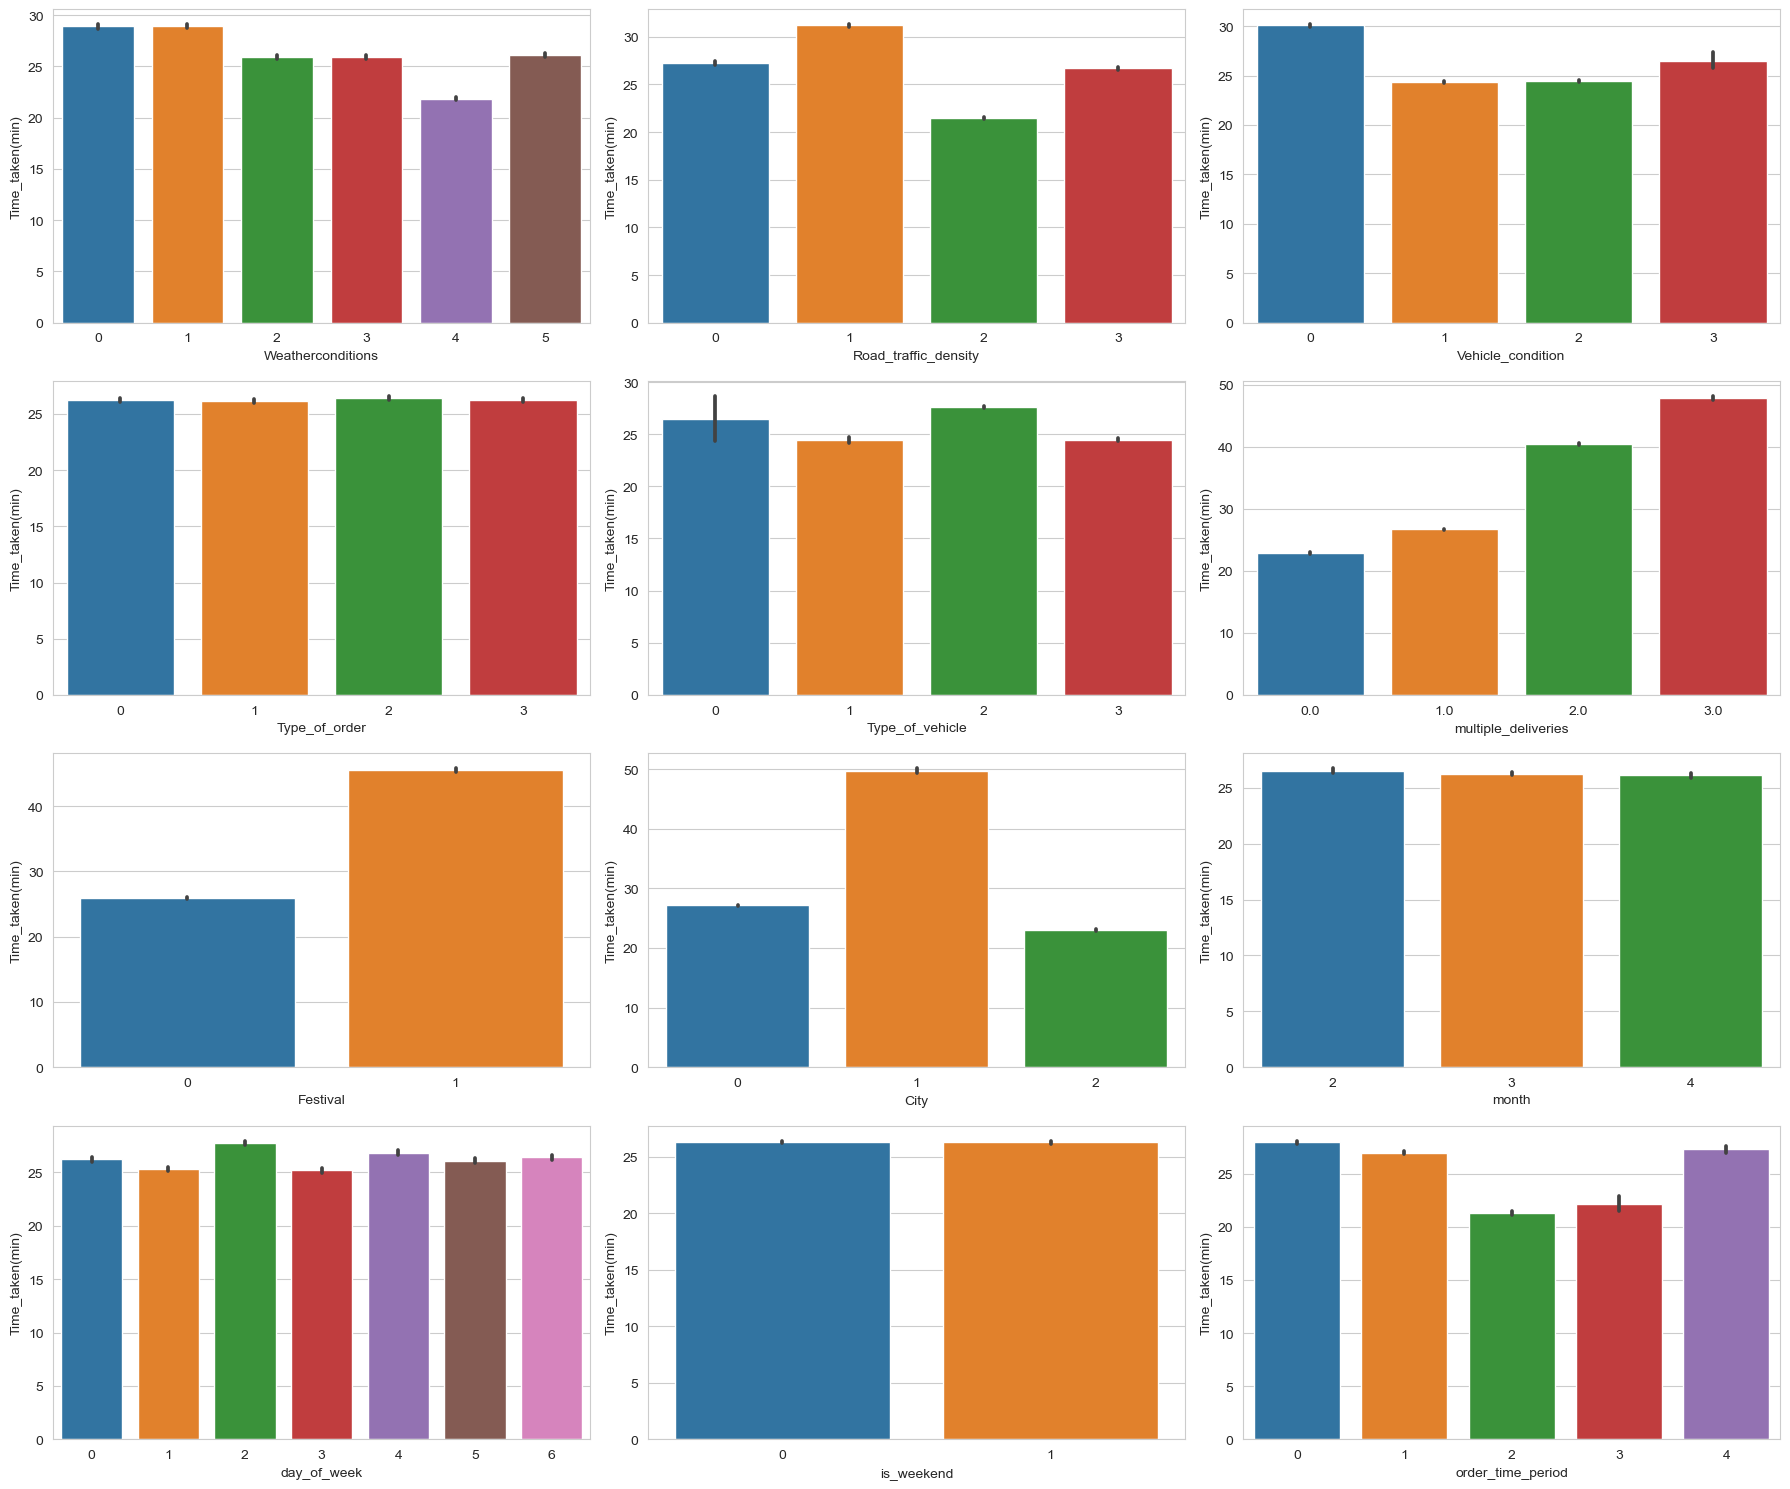

In [33]:
fig, axes = plt.subplots(round(len(cat_cols) / 3), 3, figsize=(18, 15))

for i, ax in enumerate(fig.axes):
    if i < len(cat_cols):
        sns.barplot(x=cat_cols[i], y="Time_taken(min)", data=df, ax=ax)
fig.tight_layout()


<Figure size 1000x800 with 0 Axes>

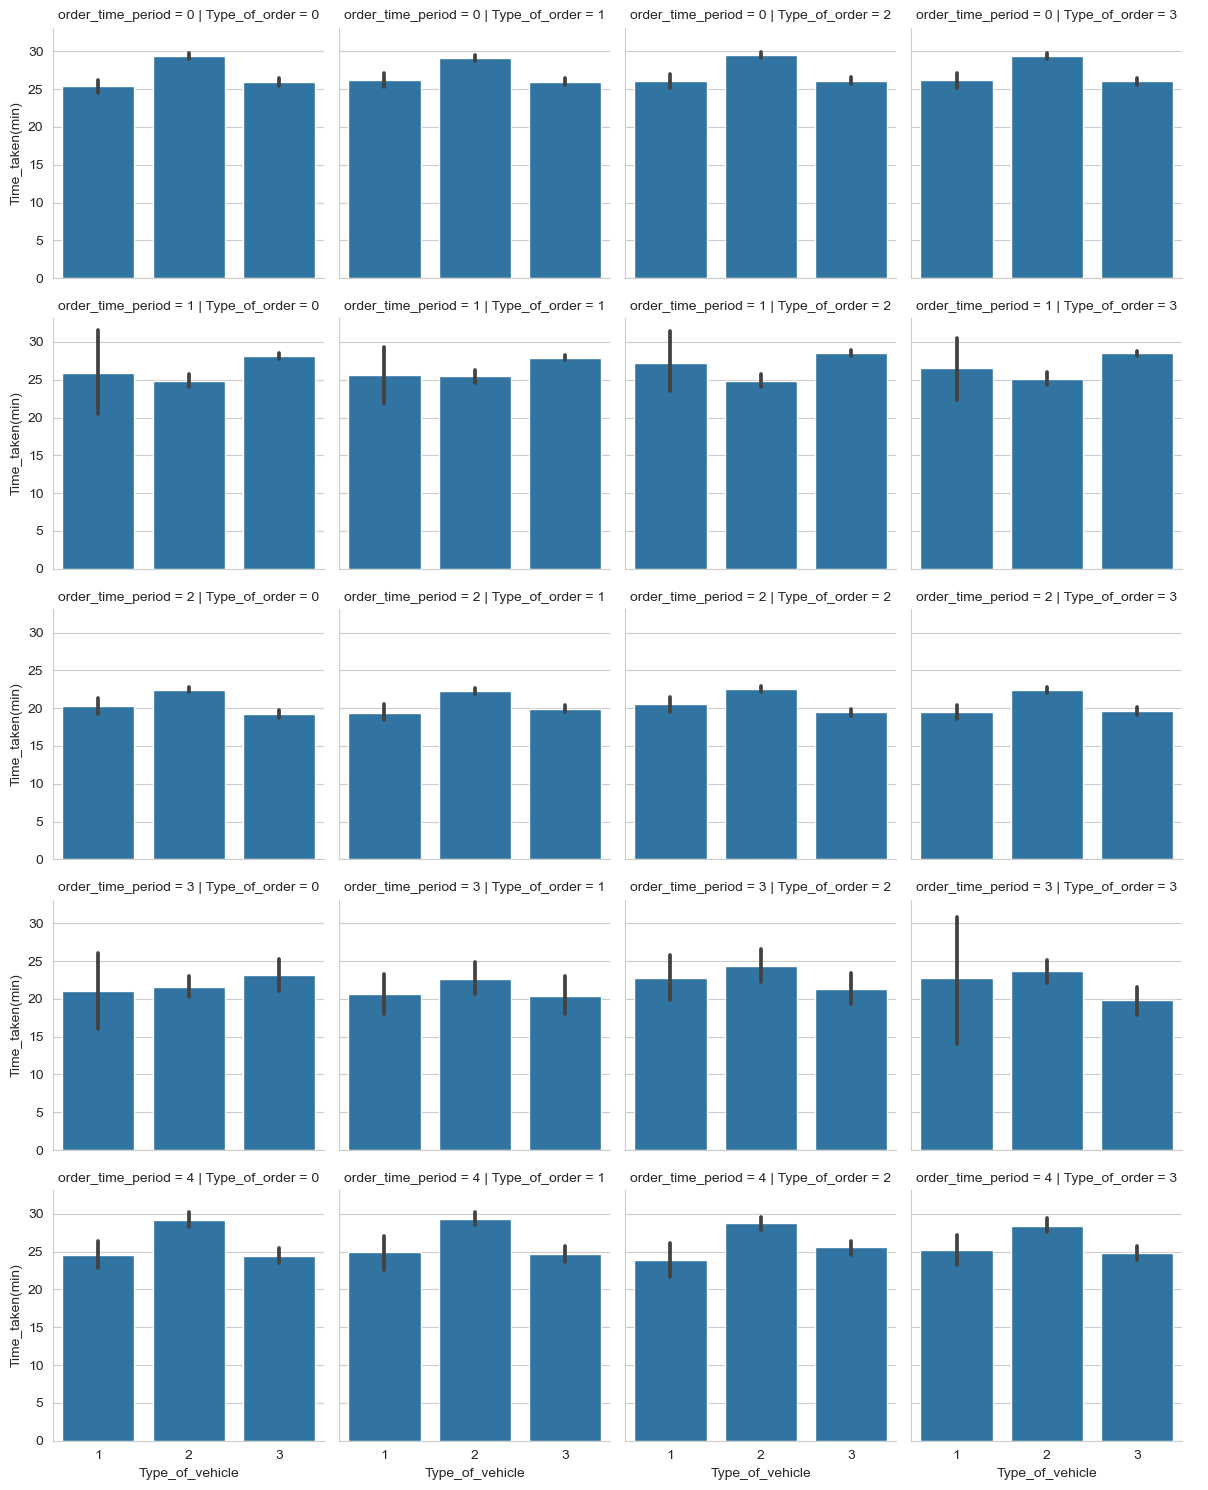

In [34]:
c=["month", "is_weekend", "Type_of_order"]

plt.figure(figsize=(10,8))
g = sns.FacetGrid(df, col=c[2], row="order_time_period")
g.map(sns.barplot, "Type_of_vehicle", "Time_taken(min)")
g.add_legend()

plt.show()


<Figure size 1000x800 with 0 Axes>

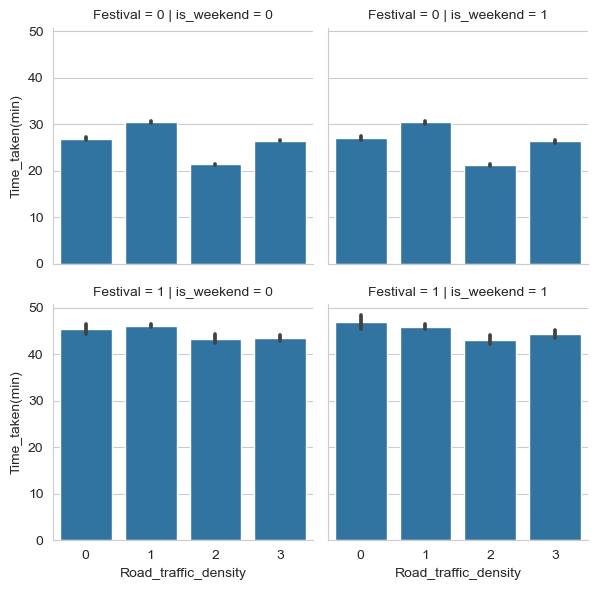

In [35]:
plt.figure(figsize=(10,8))
g = sns.FacetGrid(df, col=c[1], row="Festival")
g.map(sns.barplot, "Road_traffic_density", "Time_taken(min)")
g.add_legend()

plt.show()

<Figure size 1000x800 with 0 Axes>

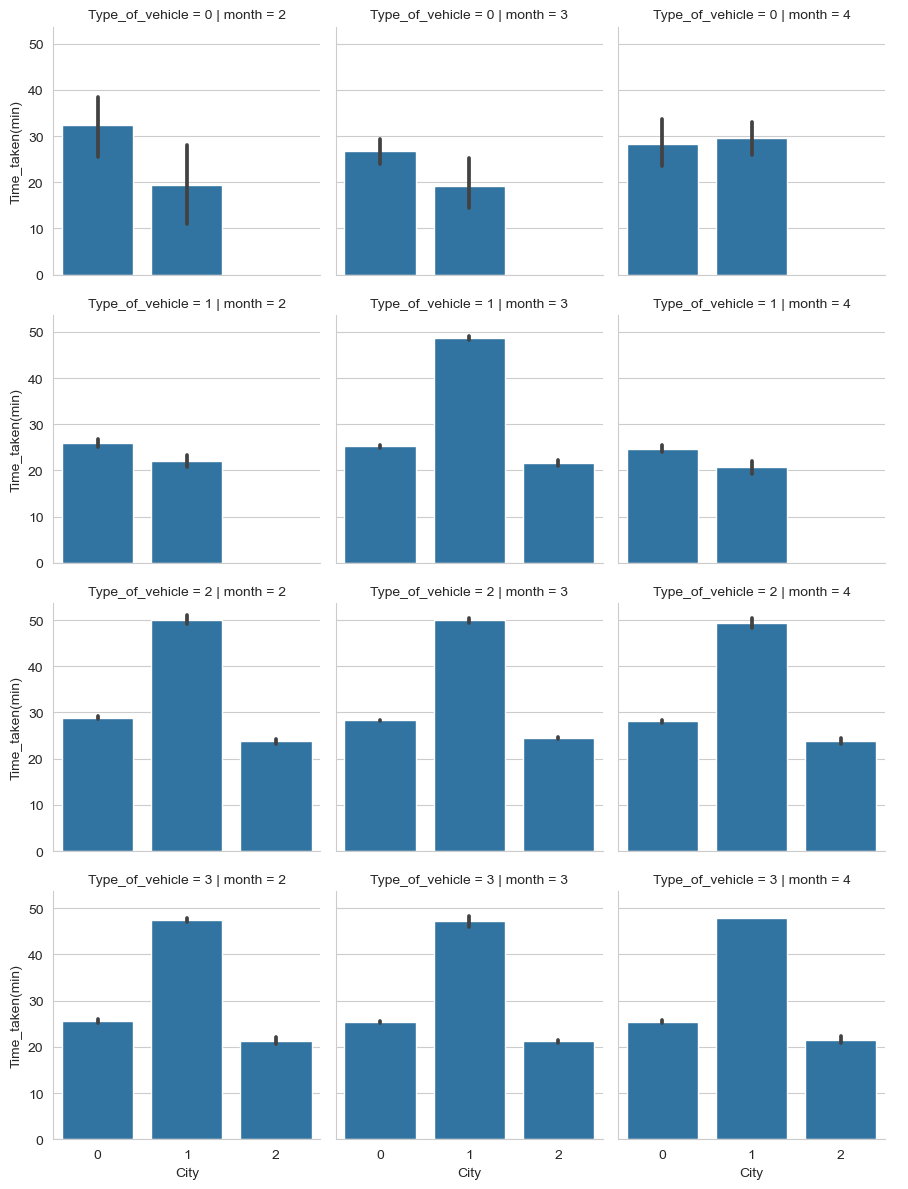

In [36]:
plt.figure(figsize=(10,8))
g = sns.FacetGrid(df, col=c[0], row="Type_of_vehicle")
g.map(sns.barplot, "City", "Time_taken(min)")
g.add_legend()


plt.show()

In [37]:
# drop year variable
def drop_cat_vars(data):
    data.drop("year",axis=1,inplace=True)
    return data
df=drop_cat_vars(df)
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Code,day,month,day_of_week,is_weekend,order_prepare_time,order_time_period,distance
0,37.0,4.9,4,0,2,3,2,0.0,0,2,24,10,19,3,5,1,15.0,2,3.03
1,34.0,4.5,3,1,2,3,3,1.0,0,0,33,3,25,3,4,0,5.0,0,20.18
2,23.0,4.4,2,2,0,1,2,1.0,0,2,26,3,19,3,5,1,15.0,2,1.55
3,38.0,4.7,4,3,0,0,2,1.0,0,0,21,6,5,4,1,0,10.0,0,7.79
4,32.0,4.6,0,0,1,3,3,1.0,0,0,30,5,26,3,5,1,15.0,4,6.21


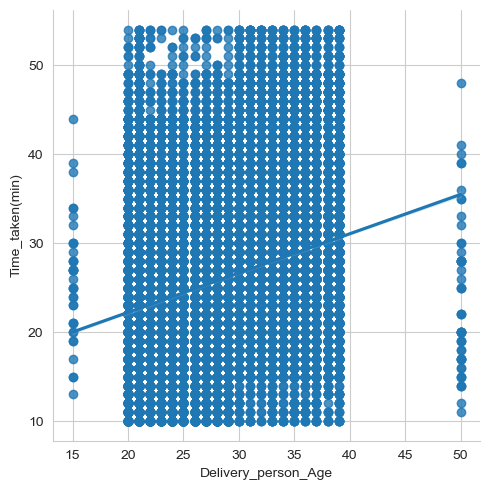

In [38]:
#Effect of numerical variables on the dependent variable
sns.lmplot(data=df,x="Delivery_person_Age",y="Time_taken(min)");
#There is a linear relationship between the courier's age and delivery time

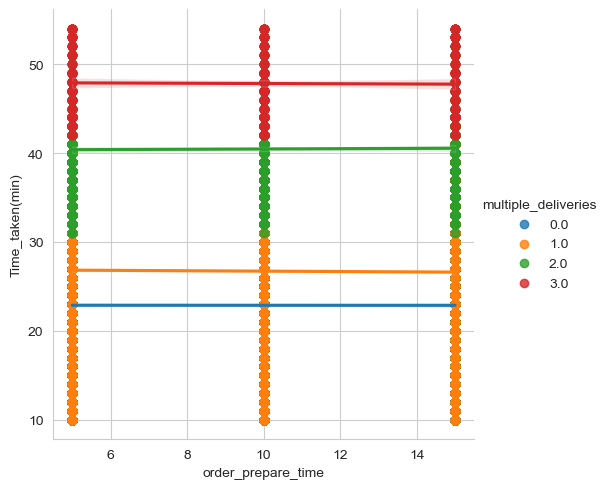

In [39]:
sns.lmplot(data=df,x="order_prepare_time",y="Time_taken(min)",hue="multiple_deliveries");

### Order preparation time does not seem to have any impact on delivery time. Let's remove the order_prepare_time variable from the data set

In [40]:
# drop order_prepare_time variable
def drop_num_vars(data):
    data.drop("order_prepare_time",axis=1,inplace=True)
    return data

df=drop_num_vars(df)
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Code,day,month,day_of_week,is_weekend,order_time_period,distance
0,37.0,4.9,4,0,2,3,2,0.0,0,2,24,10,19,3,5,1,2,3.03
1,34.0,4.5,3,1,2,3,3,1.0,0,0,33,3,25,3,4,0,0,20.18
2,23.0,4.4,2,2,0,1,2,1.0,0,2,26,3,19,3,5,1,2,1.55
3,38.0,4.7,4,3,0,0,2,1.0,0,0,21,6,5,4,1,0,0,7.79
4,32.0,4.6,0,0,1,3,3,1.0,0,0,30,5,26,3,5,1,4,6.21


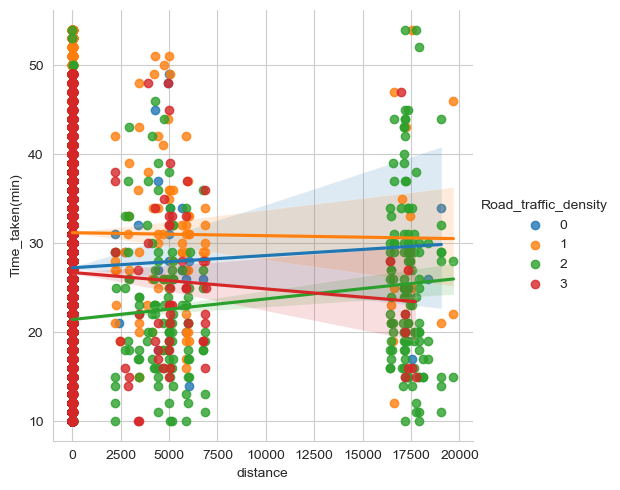

In [41]:
sns.lmplot(data=df,x="distance",y="Time_taken(min)",hue="Road_traffic_density");

### We can observe that the delivery time decreases when the traffic density is medium and the distance is long.
### We can observe that the delivery time increases when the traffic density is low and the distance is long.
### Couriers, freed from traffic congestion, start driving fast.

# Data Preprocessing

### Label Encoding

In [42]:
le=LabelEncoder()

cat_cols2=df.select_dtypes(include="object").columns
for i in cat_cols2:
    df[i]=le.fit_transform(df[i])
    
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Code,day,month,day_of_week,is_weekend,order_time_period,distance
0,37.0,4.9,4,0,2,3,2,0.0,0,2,24,10,19,3,5,1,2,3.03
1,34.0,4.5,3,1,2,3,3,1.0,0,0,33,3,25,3,4,0,0,20.18
2,23.0,4.4,2,2,0,1,2,1.0,0,2,26,3,19,3,5,1,2,1.55
3,38.0,4.7,4,3,0,0,2,1.0,0,0,21,6,5,4,1,0,0,7.79
4,32.0,4.6,0,0,1,3,3,1.0,0,0,30,5,26,3,5,1,4,6.21


## Train Test Split

In [43]:
X=df.drop("Time_taken(min)",axis=1)
y=df["Time_taken(min)"]

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(32826, 17)
(32826,)
(3648, 17)
(3648,)
(9119, 17)
(9119,)


In [44]:
sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_val=sc.transform(X_val)
X_test = sc.transform(X_test)

In [45]:
#Organizing Test Data Set
#We will pre-process the test data set to give it to the model.
test=pd.read_csv("/Users/rammanyala/Downloads/FOOD DELIVERY/test.csv")
test_Id=test["ID"]

In [46]:
def update_datatypes():
    


    def prep_test_data(data):
        data=extract_data(data)
        data.drop(["ID","Delivery_person_ID"],axis=1,inplace=True)
        data=update_datatypes(data)
        data=fill_na_values(data)
        data=extract_date_features(data)
        data=calculate_prepare_time_and_extract(data)
        data=distance(data)
        data=drop_cat_vars(data)
        data=drop_num_vars(data)
        # Encoding
        cat_cols3=data.select_dtypes(include="object").columns
        for i in cat_cols3:
            data[i]=le.fit_transform(data[i])
        # Normalization
        data = sc.transform(data)
        return data

    test_sc=prep_test_data(test)    

# model building


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

models = {
    'LinearRegression': {
        'model': LinearRegression()
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor()
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=0)
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=0)
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(random_state=0)
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=0)
    },
    'XGBRegressor': {
        'model': XGBRegressor()
    }
}


In [48]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Define a custom scoring function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Assuming X_train, y_train are defined
# Assuming models dictionary is defined as a dictionary
models = {
    'LinearRegression': {
        'model': LinearRegression()
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor()
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=0)
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=0)
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(random_state=0)
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=0)
    },
    'XGBRegressor': {
        'model': XGBRegressor()
    }
}

for model_name, model_info in models.items():
    model = model_info['model']
    scoring = {'r2': 'r2', 'rmse': make_scorer(rmse, greater_is_better=False)}
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    mean_r2 = scores['test_r2'].mean()
    mean_rmse = -scores['test_rmse'].mean()  # we use negative because make_scorer flips the sign for RMSE
    print(f"Model: {model_name}")
    print(f"Mean R^2: {mean_r2}")
    print(f"Mean RMSE: {mean_rmse}")
    print()



Model: LinearRegression
Mean R^2: 0.469891431286665
Mean RMSE: 6.8403711589182326

Model: KNeighborsRegressor
Mean R^2: nan
Mean RMSE: nan

Model: RandomForestRegressor
Mean R^2: 0.8114106432263666
Mean RMSE: 4.079937890215044

Model: GradientBoostingRegressor
Mean R^2: 0.7702567997619388
Mean RMSE: 4.50322830618005

Model: AdaBoostRegressor
Mean R^2: 0.5737977176210558
Mean RMSE: 6.133002367430199

Model: DecisionTreeRegressor
Mean R^2: 0.6455112016391423
Mean RMSE: 5.593374434862729

Model: XGBRegressor
Mean R^2: 0.8100089165836426
Mean RMSE: 4.095134110987384



In [49]:
#Random forest, gradient boosting and xgboost algorithms gave the best results. Let's do hyperparameter optimization for these three models:
models=["RandomForestRegressor","GradientBoostingRegressor","XGBRegressor"]
regresions=[RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=0), XGBRegressor()]
# For hiperparameter tuning:

params={
    models[0]:{"max_features":[1,3,10],
              "min_samples_split":[2,3,10],
              "min_samples_leaf":[1,3,10],
              "n_estimators":[100,300,500]
              },
    models[1]:{"learning_rate":[0.1,0.01],
               "n_estimators":[100,300,500],
               "subsample":[0.5,0.7,1.0],
               "min_samples_split":[2,3,10],
               "min_samples_leaf":[1,3,10]
              },
    models[2]:{"eta":[0.1,0.3,0.5],
               "max_depth":[3,7,10],
               "min_child_weight":[1,3,6],
               "subsample":[0.5,0.7,1.0]}
}

In [50]:
def solution(model):
    model.fit(X_train,y_train)
    return model

def score(model2):
    predict=solution(model2).predict(X_test)
    r2=r2_score(y_test,predict)
    rmse=mean_squared_error(y_test,predict,squared=True)
    return [r2,rmse]

In [51]:
models2=["RandomForestRegressor No optimization","GradientBoostingRegressor No optimization","XGBRegressor No optimization",
         "RandomForestRegressor","GradientBoostingRegressor","XGBRegressor"]
regression2=[RandomForestRegressor(random_state=0),GradientBoostingRegressor(random_state=0),XGBRegressor(),
             RandomForestRegressor(random_state=0,max_features=10,min_samples_split=10,min_samples_leaf=1,n_estimators=500),
             GradientBoostingRegressor(random_state=0,learning_rate=0.1,subsample=1.0,min_samples_split=2,min_samples_leaf=3,
                                       n_estimators=500),
             XGBRegressor(eta=0.1,max_depth=7,min_child_weight=6,subsample=1.0)]

r2=[]
rmse=[]
for i in regression2:
    r2.append(score(i)[0])
    rmse.append(score(i)[1])

In [52]:
df=pd.DataFrame(models2,columns=["Model Name"])
df["R2_Score"]=r2
df["RMSE"]=rmse
df

,Model Name,R2_Score,RMSE
0,RandomForestRegressor No optimization,0.811548,16.523110
1,GradientBoostingRegressor No optimization,0.768022,20.339392
2,XGBRegressor No optimization,0.811748,16.505576
3,RandomForestRegressor,0.819271,15.845993
4,GradientBoostingRegressor,0.789183,18.484046
5,XGBRegressor,0.822986,15.520268


### The hyperparameter optimized XGBoost algorithm gave the best results. Let's observe how we predicted the values in the first 50 observations with the XGBoost model:



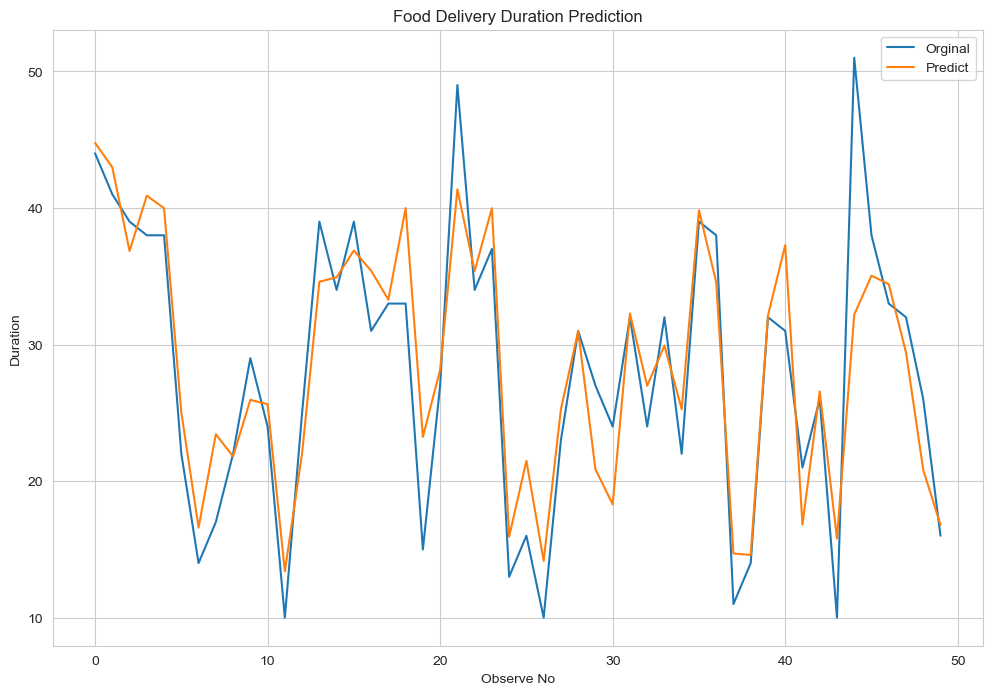

In [53]:
xgb=XGBRegressor(eta=0.1,max_depth=7,min_child_weight=6,subsample=1.0)
xgb.fit(X_train,y_train)
y_pred1=xgb.predict(X_test)

plt.figure(figsize=(12,8))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Orginal")
plt.plot(range(len(y_test[:50])),y_pred1[:50],label="Predict")
plt.title("Food Delivery Duration Prediction")
plt.ylabel("Duration")
plt.xlabel("Observe No")
plt.legend()
plt.show()

### Predicting Test data set

In [54]:
y_pred1=xgb.predict(X_test)

In [55]:
y_pred1

array([44.765774, 42.980965, 36.84817 , ..., 22.661997, 25.239622,
       27.944773], dtype=float32)